# Code for large grids
The goal of this notebook is to look at large grids and try to use the BLP method to preict the probability of success of the walk.

The first part implement the QW model, the second part implement the equations of BLP for the approximation using the eigenvalues and the last part plots some figures comparing the approximation and the true probability.
## 1. QW Model

In [1]:
# Maths and data management
import math
from math import pi
import numpy as np
import pandas as pd
import pickle

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Fitting curves
from scipy.optimize import curve_fit

# Plotting configuration
%matplotlib inline
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

In [2]:
def kron_power(U,n):
    """
    Entries :
        U -> A numpy matrix.
        n -> An integer.
    Output :
        U to the kronecker power n.
    """
    tmp = np.array([[1.]])
    for i in range(n):
        tmp = np.kron(tmp,U)
    return tmp
def dot_multiple(l):
    """
    Entry :
        l -> A list of numpy matricies.
    Output :
        The dot product of all the matricies in l.
    """
    assert(len(l)!=0)
    tmp = np.eye(len(l[0]))
    for i in range(len(l)):
        tmp = np.dot(tmp,l[i])
    return tmp

def get_proba(psi):
    """
    Entry :
        psi -> The state of the quantum walk.
    Output :
        The probability to be in each position of the grid in the form of a matrix of size NxN$
    """
    N = int(np.sqrt(len(psi)/2))
    l = np.array([np.abs(psi[i])**2+np.abs(psi[N*N+i])**2 for i in range(N*N)])
    return np.reshape(l,(N,N))

def get_matrix_qw(nb,search=[]):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
    Outputs : {1},{2}
        {1} -> The operator U of the walk.
        {2} -> The operator U' of the search (walk and oracle).
    """
    
    def mod_number(x,N):
        l = list(map(int,list(bin(x)[2:])))
        l = [0]*(N-len(l))+l
        l = [l[len(l)-i-1] for i in range(len(l))]
        y = 0
        for i in range(N):
            y += l[(i+N//2)%N]*2**i
        return y
    

    N = 2**nb

    X = np.array([[1 if (i-j+N)%N == 1 else 0 for j in range(N)] for i in range(N)],dtype=float)
    sig = np.array([[X[i,j] if i<N and j<N else (X[j-N][i-N]if i>=N and j>=N else 0) for j in range(2*N)] for i in range(2*N)],dtype=float)
    U_trans = np.kron(sig,np.eye(N)) # sig \otimes I_N
    
    SW = np.array([[1 if mod_number(i,2*nb)==j else 0 for j in range(N*N)] for i in range(N*N)],dtype=float)
    U_swap = np.kron(np.eye(2),SW) # I_2 \otimes SW
    
    Cx = np.array([[1,1j],[1j,1]])/np.sqrt(2) # Coin X
    U_Xcoin = np.kron(Cx,np.eye(N*N))
    
    Cy = np.array([[1,-1j],[-1j,1]])/np.sqrt(2) # Coin Y
    U_Ycoin = np.kron(Cy,np.eye(N*N))
    
    U = dot_multiple([U_swap,U_trans,U_swap,U_Ycoin,U_trans,U_Xcoin])
    
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R) # Oracle
    
    return U,np.dot(U,U_R)

## 2. Eigenvalues

The goal of this part is to approximate the signal of the walk using the method in BLP.

We note $U' = UR$ the operator of the walk including the oracle. We also define 
$$ 0<\lambda_1 < \ldots < \lambda_l $$
and 
$$ 0>\lambda_1' > \ldots > \lambda_m' $$
Such that $e^{i\lambda_j}$ is an eigenvalue of $U'$ and $|\lambda_{j,k}\rangle$ are the corresponding eigenvectors. The multiplicty of $\lambda_i$ is noted $v(\lambda_i)$.

Now we note $|\psi(0)\rangle$ the initial state of the walk and $\mathcal{M}$ the set of marked vertices. It holds that the probability of success after $t$ steps $p(t)$ is equal to

$$ p(t) = \sum_{m\in \mathcal{M}} \left| \langle m | (U')^t | \psi(0) \right|^2$$

And if we decompose according to the eigenvalues we get

  $$ p(t) = \sum_{m\in \mathcal{M}} \left| \sum_{j,k} \langle m | \lambda_{j,k} \rangle  \langle \lambda_{j,k} | \psi(0) \rangle e^{i\lambda_{j} t} + \sum_{j,k} \langle m | \lambda_{j,k}' \rangle  \langle \lambda_{j,k}' | \psi(0) \rangle e^{i\lambda_{j}' t} + \sum_{k} \langle m | 0 \rangle  \langle 0 | \psi(0) \rangle \right|^2$$

We note the coefficient before each exponential $\sum_{k} \langle m | \lambda_{j,k} \rangle  \langle \lambda_{j,k} | \psi(0) \rangle = C(\lambda_j)$ which allows us to rewrite the equation above like this :

$$p(t)=\sum_{m\in\mathcal{M}}\left|C(0) + \sum_{j}{C(\lambda_j) e^{i\lambda_{j}t} + C(\lambda_j') e^{i\lambda_{j}'t}} \right|^2 \qquad (1)$$

Then we look only at the first order ($\lambda_1$ and $\lambda_1'$). The assumption is the the terms $\epsilon_m$ in the equation below are negligeables.

$$p(t)=\sum_{m\in\mathcal{M}}\left|C(\lambda_1) e^{i\lambda_{1}t} + C(\lambda_1') e^{i\lambda_{1}'t} + \epsilon_m \right|^2 \qquad (2)$$ 

This is the equation (4) of the BLP paper. 

The function *get_eigen()* returns the spectrum of $U'$ while the function *get_signal()* return the approximated signal $p(t)$ according to equation (1). However, the eigenvalues and associated eigenvector can be passed in parameters which allow us to only pass $\lambda_1$ and $\lambda_1'$ and thus reproduce the equation (2).


In [3]:
def get_eigen(U):
    """
    Entry : 
        U : A matrix.
    Output :
        A list of tuples (lambda_i,psi_i) where lambda_i is an eigenvalue and psi_i a corresponding eigenvector.
    This function returns the full spectrum of the matrix U using the numpy function.
    """
    norm = lambda x:np.sqrt(sum([abs(i)**2 for i in x]))
    val,vec = np.linalg.eig(U)
    l = [[np.angle(val[i]),vec[:,i]/norm(vec[:,i])] for i in range(len(val))]
    return sorted(l,key=lambda x:x[0])

In [4]:
def get_signal(nb,search,l,t):
    """
    Entries : 
        nb : Size parameter of the walk.
        search : Marked elements.
        l : List of eigenvalues/eigenvectors.
        t : Time (number of steps).
    Output :
        The probability of success p(t) approximated via the eigenvalues.
    """
    N = 2**nb
    p = 0.
    for searched in search:
        m = np.kron(np.array([1.,0.],dtype=complex), np.array([int(i == searched) for i in range(N**2)],dtype=complex))
        f = lambda u:sum(u*m)*sum(u.conjugate())/np.sqrt(N*N*2.)
        p += abs(sum([f(vec)*np.exp(1j*lbd*t) for lbd,vec in l]))**2
        
        m = np.kron(np.array([0.,1.],dtype=complex), np.array([int(i == searched) for i in range(N**2)],dtype=complex))
        f = lambda u:sum(u*m)*sum(u.conjugate())/np.sqrt(N*N*2.)
        p += abs(sum([f(vec)*np.exp(1j*lbd*t) for lbd,vec in l]))**2
    return p

## 3. Simulations

In this part, we simulate some walks and plot the results. The computation are long so the data are saved in a file. However, it is possible by setting the variable *compute* at `True` to compute all the results again.

The goal of these simulations is mainly to see if eq (2) with $\epsilon_m=0$ predicts $p(t)$ correctly. For each simulations, we plot the signal of the walk as well as $\tilde p(t,k)$ for $k\in \{1,2,-1\}$. 

In [5]:
U_save = []

for i in range(1,6):
    tmp,_ = get_matrix_qw(i,[])
    U_save.append(tmp)

In [6]:
data = pd.DataFrame()
data["id"]=[]
data["N"]=[]
data["nb_defect"] = []
data["search"] = []
data["steps"] = []
data["proba"] = []
data["eigen"] = []

In [7]:
def qw(nb,search,m=-1,simul_id=0):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output : {1},{2}
        [1} -> The list of the steps for which we make a measurement.
        {2} -> The probability of success for each step between 0 and m included.
    Note : The function will append the result of the simulation to the pandas dataframe "data".
    """
    global U_save
    global data
    
    N = 2**nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(nb,[])
        U_save.append(tmp)
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    p=[]
    M=[]
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    M.append(0)
    res = get_proba(psi)
    p.append(sum([res[i//N,i%N] for i in search]))
    
    for i in range(1,m+1):
        print("\rCurrently at step {} over {}".format(i,m),end="")
        M.append(i)
        psi = np.dot(U,psi)
        res = get_proba(psi)
        p.append(sum([res[i//N,i%N] for i in search]))
    print("\rDone"+" "*100,end="")
        
    print("\rGetting eigenvalues ...",end="")
    print("\rDone"+" "*100,end="\n")
    tmp = pd.DataFrame({"id":[simul_id],"N":[N],"nb_defect":[len(search)],"search":[search],"steps":[M],"proba":[p],"eigen":[get_eigen(U)]})
    data=data.append(tmp) # Add to the dataset.
    return M,p

In [8]:
compute = False

if compute:
    nb = 1
    N = 8
    search = [[0],[0,1],[0,2],[0,N+1],[0,2*N+2]]
    print("Grid size {}x{}".format(N,N))
    for i in range(nb,nb+len(search)):
        print("Simul {} :".format(i))
        qw(int(np.log2(N)),search[i-nb],500,simul_id=i)
if compute:
    nb = 6
    N = 32
    search = [[0],[0,1],[0,2],[0,N+1],[0,2*N+2]]
    print("Grid size {}x{}".format(N,N))
    for i in range(nb,nb+len(search)):
        print("Simul {} :".format(i))
        qw(int(np.log2(N)),search[i-nb],500,simul_id=i)
if compute:
    nb = 11
    N = 64
    search = [[0,N+1]]
    print("Grid size {}x{}".format(N,N))
    for i in range(nb,nb+len(search)):
        print("Simul {} :".format(i))
        qw(int(np.log2(N)),search[i-nb],500,simul_id=i)

if not compute:
    data = pickle.load(open("data.save","rb"))

In [9]:
def print_qw(nb_simul, ax, m=50, eigen_order=1):
    """
    Function to print the signal stocked into data.
    Entries :
        nb_simul -> ID of the simulation you want to look at. Print data to see which ID are available.
        ax -> matplotlib axis to plot the figure.
        m -> The number of steps to print.
        eigen_order -> The number of different positive (and negative) eigenvalues we consider. If put to -1, every eigenvalues are used.
    Output :
        List of the eigenvalues used (with multiplicity).
    """
    current = data[data.id==nb_simul]
    N = int(list(current["N"])[0])
    nb = int(np.log2(N))
    search = list(current["search"])[0]
    l = list(current["eigen"])[0]
    tmp = np.array(current[["steps","proba"]])[0]
    M = np.array(tmp[0])
    p = np.array(tmp[1])

    #print("Grid size : {}x{}\nMarked elements : {}".format(N,N,"{"+" ; ".join(["({},{})".format(i//N,i%N) for i in search])+"}"))


    k=eigen_order

    lbd = min([(lbd,vec) for lbd,vec in l if lbd > 1e-10],key=lambda x:x[0])
    lbd2 = max([(lbd,vec) for lbd,vec in l if lbd < -1e-10],key=lambda x:x[0])

    l_neg = sorted([i for i in l if i[0] < -1e-10],key=lambda x:-x[0])
    l_pos = sorted([i for i in l if i[0] > 1e-10],key=lambda x:x[0])

    l1=[]
    if k == -1:
        l1=l
    else:  
        for j in range(k):
            l1 += [i for i in l_pos if abs(i[0]-l_pos[0][0]) < 1e-10]
            l_pos = [i for i in l_pos if abs(i[0]-l_pos[0][0]) >= 1e-10]
            l1 += [i for i in l_neg if abs(i[0]-l_neg[0][0]) < 1e-10]
            l_neg = [i for i in l_neg if abs(i[0]-l_neg[0][0]) >= 1e-10]


    f = lambda t:get_signal(nb,search,l1,t)

    t = np.array(list(range(m)))



    ax.plot(M[:len(t)],p[:len(t)],'o--',label="walk")
    ax.plot(t,[f(i) for i in t],"-",label="prediction")
    
    ax.set(ylabel="{"+" ; ".join(["({},{})".format(i//N,i%N) for i in search])+"}")
    #ax.legend()
    return sorted([i for i,_ in l1])

### Grid of 8x8 

There is 5 configurations of marked elements :

- $\{(0,0)\}$
- $\{(0,0),(0,1)\}$
- $\{(0,0),(0,2)\}$
- $\{(0,0),(1,1)\}$
- $\{(0,0),(2,2)\}$

And there is 3 order plotted for the approximation $\tilde p$ : order 1, order 2 and all the eigenvalues.

We can see that for some configurations of marked elements, order 1 fails completely to predict the signal. order 2 gives better results.

### 

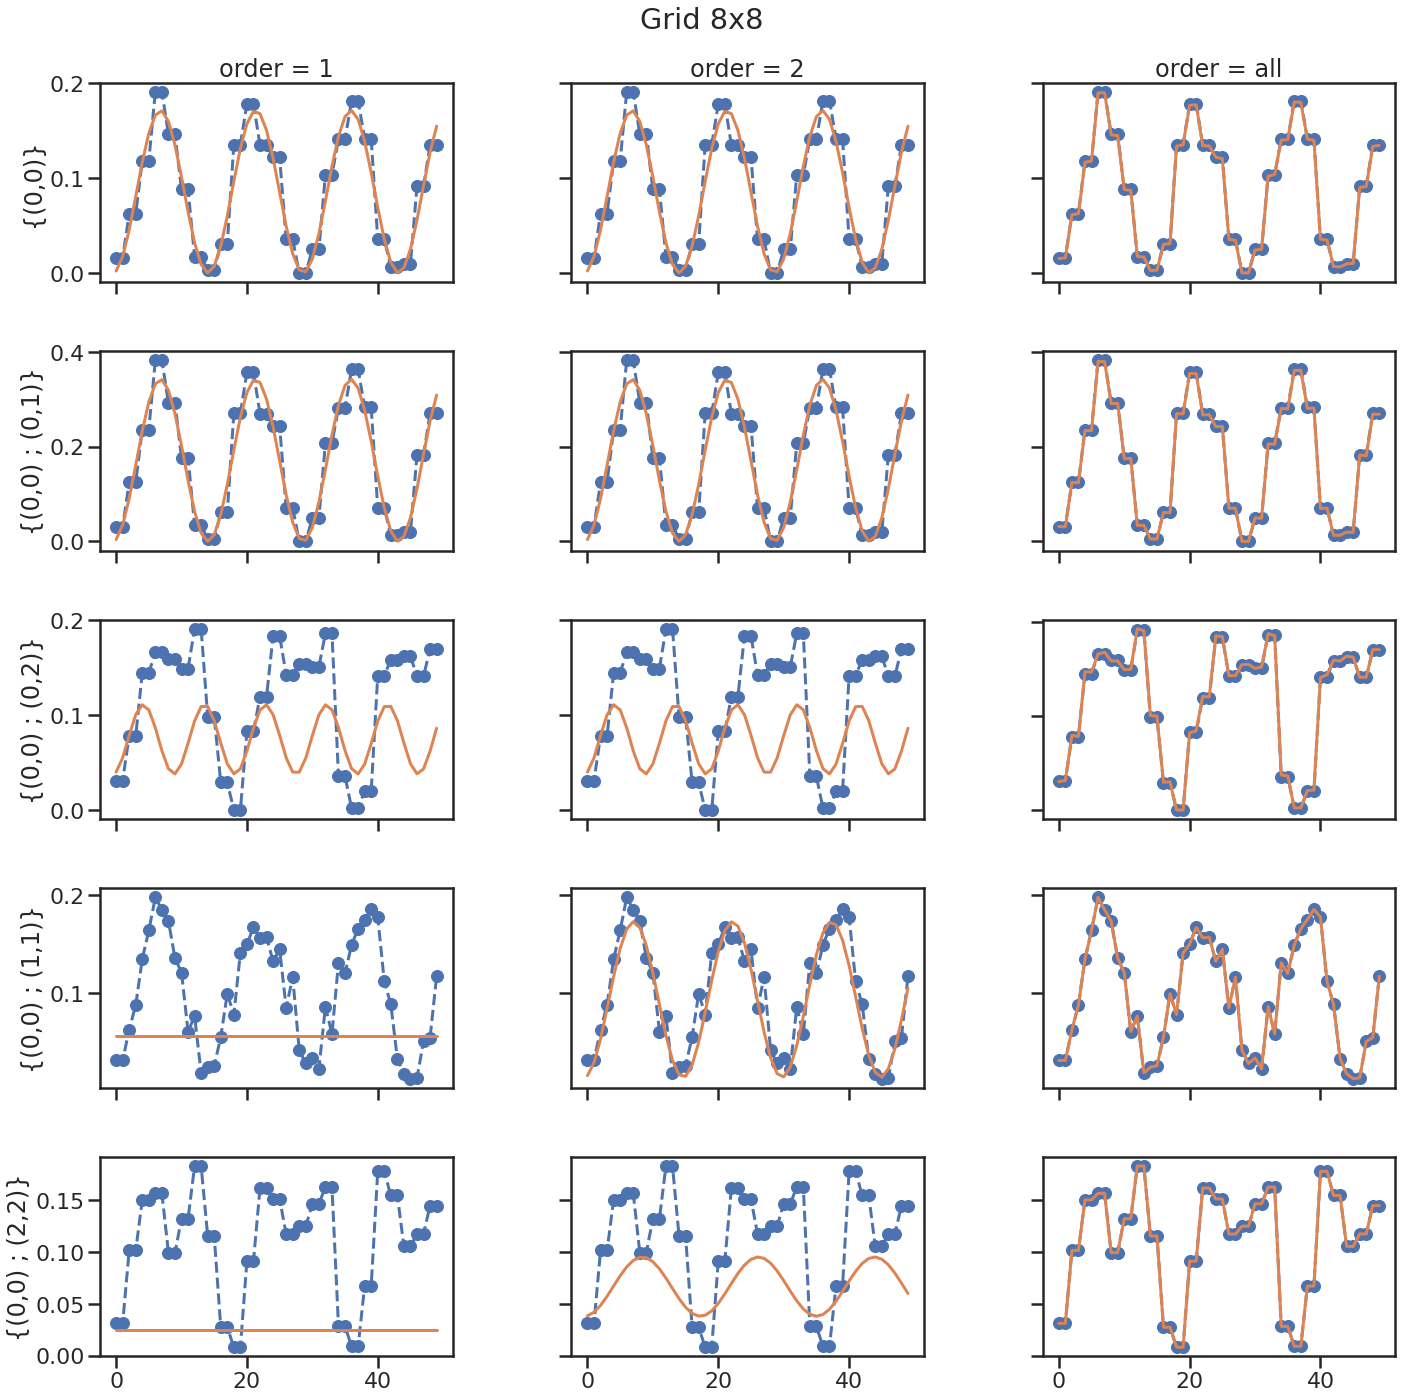

In [10]:
fig,ax = plt.subplots(5,3,figsize=(20,20))
fig.suptitle('Grid 8x8')

for i in range(5):
    print_qw(1+i, ax[i][0], m=50, eigen_order=1)
    
for i in range(5):
    print_qw(1+i, ax[i][1], m=50, eigen_order=2)
    
for i in range(5):
    print_qw(1+i, ax[i][2], m=50, eigen_order=-1)
    
ax[0,0].set_title("order = 1")
ax[0,1].set_title("order = 2")
ax[0,2].set_title("order = all")
fig.tight_layout()
    
for ax in fig.get_axes():
    ax.label_outer()

### Grid of 32x32

Same as the grid 8x8.

There is 5 configurations of marked elements :

- $\{(0,0)\}$
- $\{(0,0),(0,1)\}$
- $\{(0,0),(0,2)\}$
- $\{(0,0),(1,1)\}$
- $\{(0,0),(2,2)\}$

And there is 3 order plotted for the approximation $\tilde p$ : order 1 and order 2.

The results on small grids seem to be confirmed with a size of 32x32.

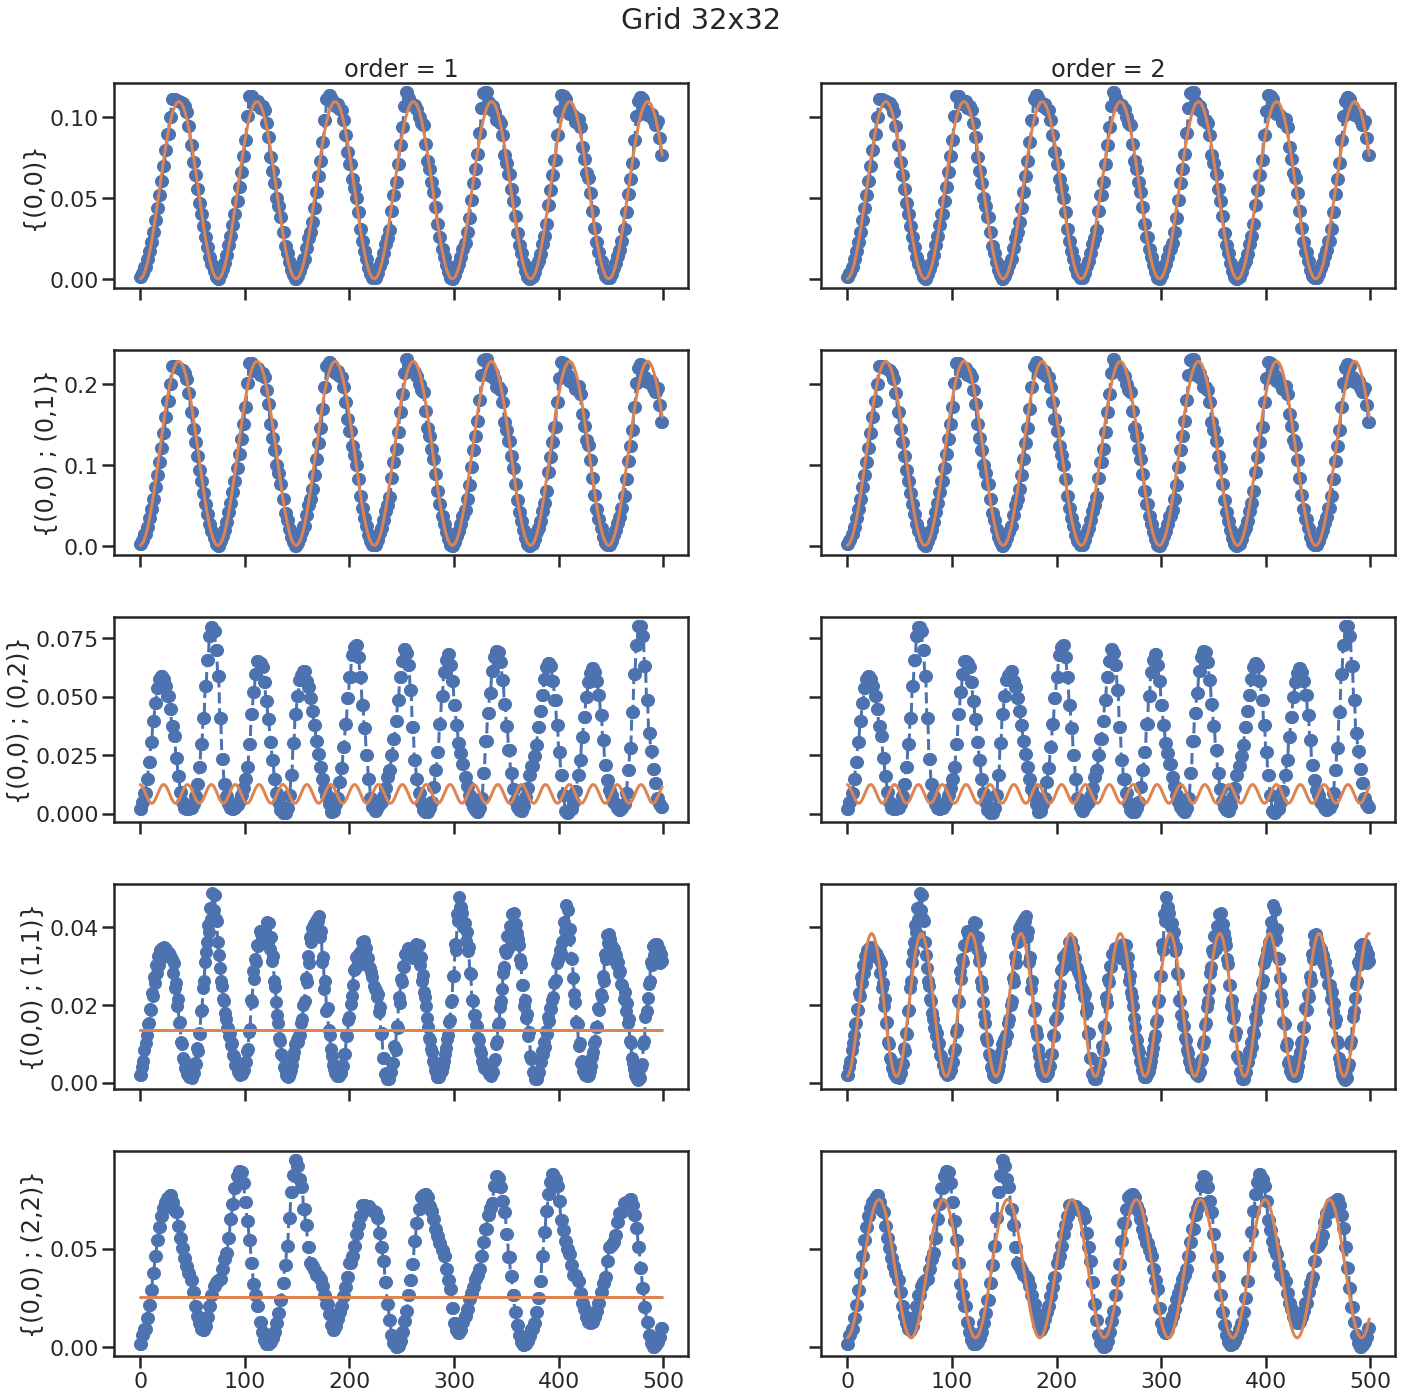

In [11]:
fig,ax = plt.subplots(5,2,figsize=(20,20))
fig.suptitle('Grid 32x32')

for i in range(5):
    print_qw(6+i, ax[i][0], m=500, eigen_order=1)
    
for i in range(5):
    print_qw(6+i, ax[i][1], m=500, eigen_order=2)
    
    
ax[0,0].set_title("order = 1")
ax[0,1].set_title("order = 2")
fig.tight_layout()
    
for ax in fig.get_axes():
    ax.label_outer()

### Grid of 64x64

Here we look only at one configuration (because it takes a long time to compute it). We look at the configuration $\{(0,0),(1,1)\}$ which seems problematic  for the first order.

Once again, the order 1 fails to predict the signal while order 2 succeeds.

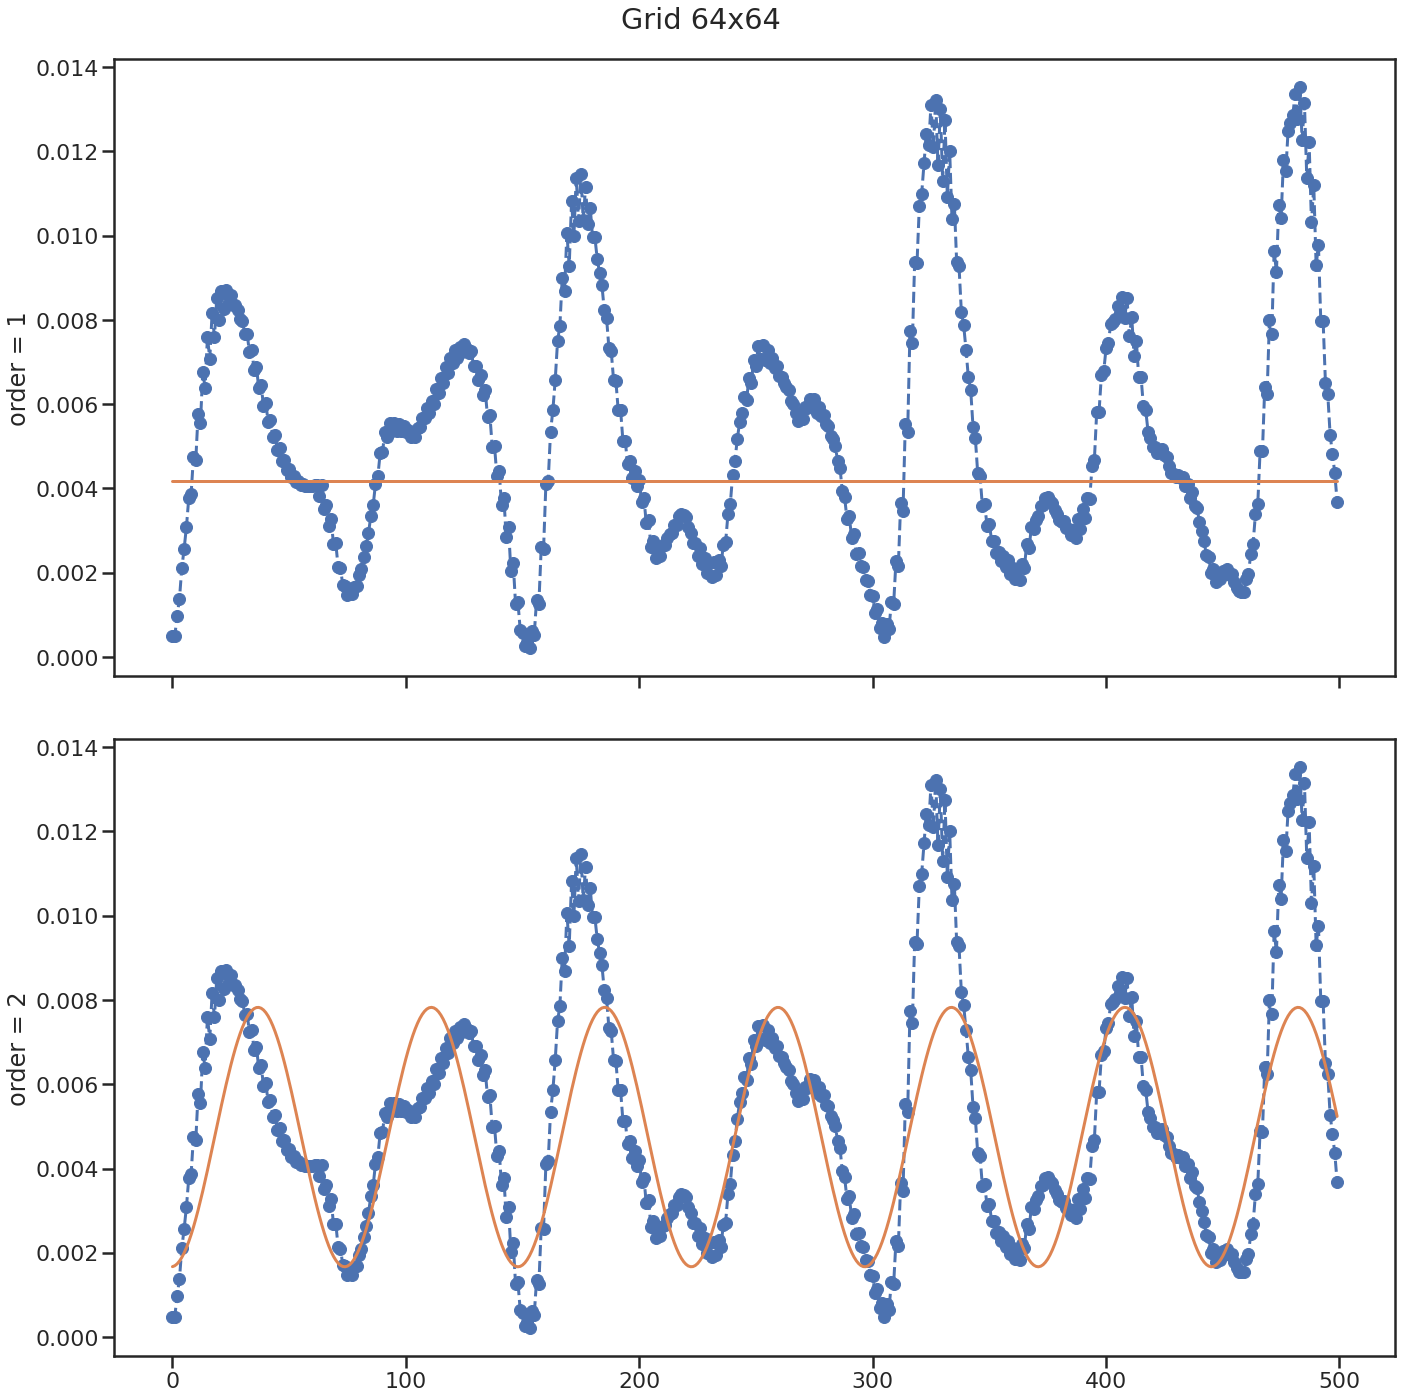

In [12]:
fig,ax = plt.subplots(2,1,figsize=(20,20))
fig.suptitle('Grid 64x64')


print_qw(11, ax[0], m=500, eigen_order=1)

print_qw(11, ax[1], m=500, eigen_order=2)
    
ax[0].set(ylabel="order = 1")
ax[1].set(ylabel="order = 2") 
fig.tight_layout()


    
for ax in fig.get_axes():
    ax.label_outer()